<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Predicting Shots Made Per Game by Kobe Bryant

_Authors: Kiefer Katovich (SF)_

---

In this lab you'll be using regularized regression penalties — ridge, lasso, and elastic net — to try and predict how many shots Kobe Bryant made per game during his career.

The Kobe Shots data set contains hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model, considering the limited number of observations (games) we have available. Plus, many of the predictors have significant multicollinearity. 


**Warning:** Some of these calculations are computationally expensive and may take a while to execute. It may be worthwhile to only use a portion of the data to perform these calculations, especially if you've experienced kernel issues in the past.

---

### 1) Load packages and data.

In [33]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [34]:
kobe = pd.read_csv('./datasets/kobe_superwide_games.csv')

---

### 2) Examine the data.

- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why might regularization be particularly useful for modeling this data?

In [35]:
len(kobe.columns)
# there are 645 columns

645

In [36]:
kobe.columns[0:10]

# The columns are statistics for each game against different opponents 
# column SHOTS_MADE that will be our target variable for prediction
# This is good for regularization because there are so many columns (feature selection)
# and many of the columns represent similar things (multicollinearity)

Index(['SHOTS_MADE', 'AWAY_GAME', 'SEASON_OPPONENT:atl:1996-97',
       'SEASON_OPPONENT:atl:1997-98', 'SEASON_OPPONENT:atl:1999-00',
       'SEASON_OPPONENT:atl:2000-01', 'SEASON_OPPONENT:atl:2001-02',
       'SEASON_OPPONENT:atl:2002-03', 'SEASON_OPPONENT:atl:2003-04',
       'SEASON_OPPONENT:atl:2004-05'],
      dtype='object')

---

### 3) Create predictor and target variables. Standardize the predictors.

Why is normalization necessary for regularized regressions?

Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

In [37]:
y = kobe['SHOTS_MADE'].values
X = kobe.iloc[:,1:] # iloc pick all rows , and pick all columns except SHOTS_MADE column

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_sc = ss.fit_transform(X)

# Standardization is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale.

---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.

How does it perform?

In [38]:
# instantiate
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, X_sc, y, cv=10)

print (linreg_scores)
print (np.mean(linreg_scores))

[-1.29858290e+29 -2.59869316e+28 -1.48978251e+28 -3.14728156e+27
 -9.23630736e+27 -2.58372975e+27 -3.36713371e+27 -5.84387976e+27
 -5.59906975e+27 -3.41881653e+28]
-2.347086138717075e+28


The mean R-squared is negative. All the R-squared scores are negative in cross validation.
The linear regression is performing far worse than baseline on the test sets.
It is overfitting and the redundant variables are affecting the coefficients.

---

### 5) Find an optimal value for the ridge regression alpha using `RidgeCV`.

Go to the documentation and [read how RidgeCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).

> *Hint: Once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that ridge performs best when searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit.


In [49]:
%%time
ridge_alphas = np.logspace(0, 3, 200)
# 10^0 to 10^3, run 200 samples

optimal = RidgeCV(alphas=ridge_alphas, cv=10)
optimal.fit(X_sc, y)

print (optimal.alpha_)

784.2822061337682
CPU times: total: 4min 27s
Wall time: 2min 14s


---

### 6) Cross-validate the ridge regression $R^2$ with the optimal alpha.

Is it better than the linear regression? If so, why might this be?

In [50]:
# A:
ridge = Ridge(alpha=optimal.alpha_)

ridge_scores = cross_val_score(ridge, X_sc, y, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores))

[0.58110961 0.52872951 0.4868993  0.59608415 0.52424653 0.52942795
 0.52839576 0.41162738 0.39903439 0.44507467]
0.5030629234560829


It is much better than Linear Regression. 
There is likely so much multicollinearity in the data that Linear Regression overfits. Ridge is able to manage the multicollinearity and get a good out-of-sample result.

---

### 7) Find an optimal value for lasso regression alpha using `LassoCV`.

Go to the documentation and [read how LassoCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). It is very similar to `RidgeCV`.

> *Hint: Again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that lasso, unlike ridge, performs best when searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide what alphas to use itself by setting the keyword argument `n_alphas=` to however many alphas you want it to search over. We recommend letting scikit-learn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if it's working, set `verbose =1`._

In [51]:
# A:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_sc, y)

print (optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.06790539979326354


---

### 8) Cross-validate the lasso $R^2$ with the optimal alpha.

Is it better than the linear regression? Is it better than ridge? What do the differences in results imply about the issues with the data set?

In [52]:
# A:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_sc, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[0.61603625 0.52641159 0.53888743 0.61322432 0.54627539 0.5554072
 0.52716822 0.44849563 0.4646267  0.51838952]
0.5354922262084527


Lasso performs much better than Linear Regression.
Lasso performs slightly better than Ridge.
Lasso deals primarily with the feature selection of valuable variables,
eliminating ones that are not useful. This also takes care of multicollinearity, but in a different way: it will choose the "best" of the correlated variables and zero-out the other redundant ones. There may also be useless variables in the data which it is simply getting rid of entirely.

---

### 9) Look at the coefficients for variables in the lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original data set are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** If you only fit the lasso within `cross_val_score`, you'll have to refit it outside of that function to pull out the coefficients.

In [53]:
# A:
lasso.fit(X_sc, y)

Lasso(alpha=0.06790539979326354)

In [54]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
# sort by largest absolute coeff first

lasso_coefs.head(20)

,variable,coef,abs_coef
579,COMBINED_SHOT_TYPE:jump_shot,1.233880,1.233880
574,SHOT_TYPE:2pt_field_goal,0.866201,0.866201
566,SHOT_ZONE_BASIC:restricted_area,0.453050,0.453050
577,COMBINED_SHOT_TYPE:dunk,0.274926,0.274926
611,ACTION_TYPE:jump_shot,-0.272130,0.272130
575,SHOT_TYPE:3pt_field_goal,0.140492,0.140492
582,SECONDS_REMAINING,0.132360,0.132360
612,ACTION_TYPE:layup_shot,-0.129658,0.129658
423,SEASON_OPPONENT:sac:1999-00,0.127065,0.127065
561,SHOT_ZONE_BASIC:above_the_break_3,0.118469,0.118469


In [61]:
lasso_coefs.shape[0]

644

In [60]:
print('Percentage of variables zeroed out:', np.sum((lasso.coef_ == 0))/lasso_coefs.shape[0])

Percentage of variables zeroed out: 0.7888198757763976


---

### 10) Find an optimal value for elastic net regression alpha using `ElasticNetCV`.

Go to the documentation and [read how ElasticNetCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note that here you'll be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: Strength of regularization.
- `l1_ratio`: Amount of ridge vs. lasso (0 = all ridge, 1 = all lasso).
    
Do not include 0 in the search for `l1_ratio` — it won't allow it and will break.

You can use `n_alphas` for the alpha parameters instead of setting your own values, which we highly recommend.

Also, be careful setting too many l1_ratios over cross-validation folds in your search. It can take a long time if you choose too many combinations and, for the most part, there are diminishing returns in this data.

In [62]:
# A:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(X_sc, y)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.07271360998818006
0.9587500000000001


---

### 11) Cross-validate the elastic net $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the ridge and lasso regularized regressions?

In [63]:
# A:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_sc, y, cv=10)

print (enet_scores)
print (np.mean(enet_scores))

[0.61742795 0.52697978 0.53864379 0.61332045 0.54728018 0.55547707
 0.52548033 0.4485161  0.46407359 0.52059974]
0.5357798983416926


Elastic net performs similar to Lasso. Elastic net performs much better than Ridge.

---

### 12. [Bonus] Compare the residuals for ridge and lasso visually.


In [64]:
# A: Maybe a jointplot?
ridge.fit(X_sc, y)
lasso.fit(X_sc, y)

Lasso(alpha=0.06790539979326354)

In [65]:
ridge_resid = y - ridge.predict(X_sc)
lasso_resid = y - lasso.predict(X_sc)

c:\Users\muzaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\muzaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


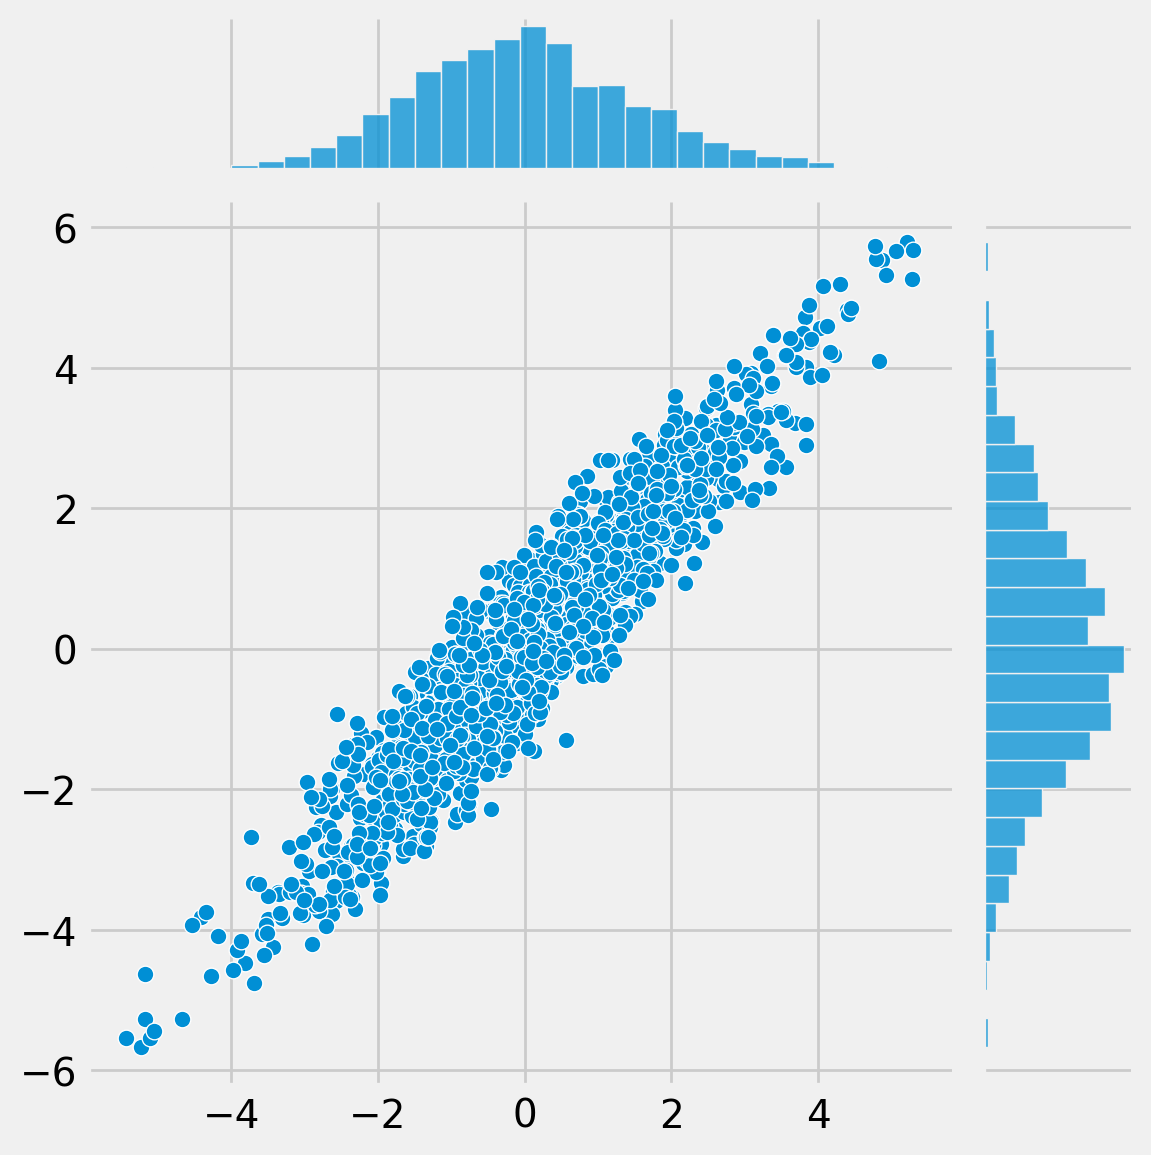

In [68]:
sns.jointplot(x=ridge_resid, y=lasso_resid)